## Eisenhower Tunnel
The following script examines traffic data at the Eisenhower tunnel on I70 East of Denver is Colorado, USA. 


If you are unfamiliar with the tunnel see the Wiki article here
https://en.wikipedia.org/wiki/Eisenhower_Tunnel


We will load the data for across multiple months and years but this is an example of how the monthly data are presented on the CDOT webpage.

#### Example Data fora  single month
https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2022/3

### Load Primary Packages

In [139]:
#Load pertinent packages

#https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/000106/true/2022/3

import os
import sys
import time
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import defaultdict


import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
# Import seaborn
import seaborn as sns


### Data Scraping

We will be working with hourly count data collected by CDOT (Colorado Dept of Transport) at numerous stations across Colorado.  We will be examining the station at the Eisehower tunnel. Data are stored with one column per hour and one row per day for each month. As written the script will pull just over 3 years of data.

In [140]:
# specify stations and dates of interest

# url to format: station ID, year, month
url =  "https://dtdapps.coloradodot.info/otis/TrafficData/GetDailyTrafficVolumeForStationByMonth/{}/true/{}/{}"


#station '000106' is on the eisenhower tunnel I70
stations = ['000106']


# period of interest
#years=[ '2015', '2016','2017', '2018','2019','2020','2021']
years=['2016','2017', '2018','2019']
months= range(1, 13)



### Define web scraping function
define function to pull hourly data for months and years of interest for the Eisenhower station ('000106').

In [141]:
#define function to pull hourly data for months and years of interest
def get_data(url, station_entry, year_entry, month_entry):
     data =[]                    
   
     for station in station_entry:
        for year in year_entry:
            for month in month_entry:
                r2=requests.get(url.format(station,year,month))
                df_list2 = pd.read_html(r2.text, skiprows=0)
                df2=df_list2[0]  #confirmed type is pd.df
                data.append(df2)                             
                
        return data 
        
station=get_data(url,stations,years,months)  



#pd.DataFrame(final)
# Examine first few rows of the data frame.
traffic_pd=pd.concat(station, axis=0)
traffic_pd.head()

# this may take 30 seconds to a  minute.

Count Date Dir   0h   1h   2h   3h   4h   5h   6h    7h    8h    9h   10h  \
0  01/01/2016   P   65   71   64   69   98  168  328   435   672   940  1412   
1  01/01/2016   S  115  118   99   90   84  108  436  1440  1684  1465  1523   
2  01/02/2016   P  102   74   78  108  183  372  694   933  1277  1741  2403   
3  01/02/2016   S  142  106   77   77  139  233  854  1631  1603  1478  1820   
4  01/03/2016   P  156  113  120  112  161  228  438   817  1336  2437  2977   

    11h   12h   13h   14h   15h   16h   17h   18h   19h   20h  21h  22h  23h  
0  1716  1777  1882  2015  2173  1764  2014  1132  1070   624  391  240  152  
1  1583  1605  1594  1529  1575  1316   998   753   607   432  326  266  201  
2  2762  2647  2259  2491  1831  1619  2200  2196  2151  1186  714  360  269  
3  1942  1960  1360  1395  1298  1221   912   687   549   476  332  291  205  
4  2858  2242  1813  1717  1752  1615  1364  1328  1201   815  548  260  148

In [142]:
# transform wide data to long

traffic_long = traffic_pd.melt(
    id_vars=['Count Date', 'Dir'],
    var_name='hour', value_name='vehicles_per_hour')


traffic_long['hour']=traffic_long['hour'].replace("h", "",regex=True)
traffic_long['hour']=traffic_long['hour'].astype('int')

#change vehicles to integer
traffic_long['vehicles_per_hour']=traffic_long['vehicles_per_hour'].astype('int')

# Specify input format
traffic_long["Count Date"] =  pd.to_datetime(traffic_long["Count Date"], format="%m/%d/%Y")
#traffic_long["Dir"] =  traffic_long['Dir'].astype("S")

#rename columns
traffic_long=traffic_long.rename(columns={"Count Date": "count_date", "Dir": "direction"})

#sort by date, hour
traffic_long = traffic_long.sort_values(by = ['count_date' ,'hour'])
traffic_long=traffic_long.reindex( )

#print main features
traffic_long.dtypes

#Data dimensions
print( "The extracted data have the following dimensions" +  str(traffic_long.shape))

#print first few rows
traffic_long.head()

The extracted data have the following dimensions(65712, 4)


count_date direction  hour  vehicles_per_hour
0    2016-01-01         P     0                 65
1    2016-01-01         S     0                115
2738 2016-01-01         P     1                 71
2739 2016-01-01         S     1                118
5476 2016-01-01         P     2                 64

### Quality check
Examine data for missing values and 5 point summaries

In [143]:


# count missing values in each column
print(traffic_long.isnull().sum())

#Check total counts
traffic_long.count()


count_date           0
direction            0
hour                 0
vehicles_per_hour    0
dtype: int64


count_date           65712
direction            65712
hour                 65712
vehicles_per_hour    65712
dtype: int64

In [144]:
#Check range of values
def min_max(df,col):
    max_value=df[col].max()
    min_value=df[col].min()
    print(min_value,max_value)
    
    
min_max(traffic_long, 'count_date')    
#
min_max(traffic_long, 'vehicles_per_hour')



2016-01-01 00:00:00 2019-12-31 00:00:00
0 5625


### Summary
Examine data for missing values and 5 point summaries

In [145]:
# calculate a 5-number summary of traffic data
from numpy import percentile
from numpy.random import rand
# generate data sample
# calculate quartiles
quartiles = percentile(traffic_long['vehicles_per_hour'], [25, 50, 75])
# calculate min/max
data_min, data_max = traffic_long['vehicles_per_hour'].min(), traffic_long['vehicles_per_hour'].max()
# print 5-number summary
print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)

Min: 0.000
Q1: 190.000
Median: 633.000
Q3: 1126.000
Max: 5625.000


In [146]:
hourly_traffic=traffic_long


Data are in good shape. 2017 appears to have some missing dates


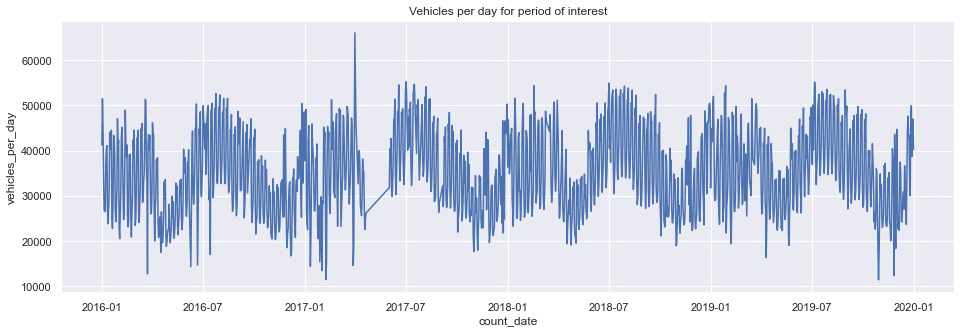

In [147]:
# Calculate daily sums regardless of direction to QC plot
daily_traffic = traffic_long.groupby('count_date').sum()
daily_traffic=daily_traffic.rename(columns={"vehicles_per_hour": "vehicles_per_day"})

# Plot all time
sns.lineplot(data=daily_traffic, x="count_date", y="vehicles_per_day").set(
    title="Vehicles per day for period of interest")
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(25,10)})
#Plot standardized to day of year


print("Data are in good shape. 2017 appears to have some missing dates")



### Identify missing rows
Missing dates are missing entirely with no row for the missing day and hour.  The following section will create one row for hour between the start and end of our period of interest. 

In [148]:
#View the existing data frame
hourly_traffic.head()

count_date direction  hour  vehicles_per_hour
0    2016-01-01         P     0                 65
1    2016-01-01         S     0                115
2738 2016-01-01         P     1                 71
2739 2016-01-01         S     1                118
5476 2016-01-01         P     2                 64

In [149]:
# create hourly data frame, duplicate for direction, join with true data
start=hourly_traffic['count_date'].min()
end=hourly_traffic['count_date'].max()

hourly_rows = pd.DataFrame(
        {'count_datetime': pd.date_range(start, end, freq='1H', closed='left')}
     )
hourly_rows['temp']=1
print(len(hourly_rows)*2)
hourly_rows.head()

70080


count_datetime  temp
0 2016-01-01 00:00:00     1
1 2016-01-01 01:00:00     1
2 2016-01-01 02:00:00     1
3 2016-01-01 03:00:00     1
4 2016-01-01 04:00:00     1

In [150]:
direction = [['P'], ['S']]
 
# Create the pandas DataFrame
direction = pd.DataFrame(direction, columns = ['direction'])
direction['temp']=1
direction.head()

direction  temp
0         P     1
1         S     1

In [151]:
hourly_rows_empty =pd.merge(
                   hourly_rows,
                   direction,
                   how="left",
                   on='temp')

hourly_rows_empty=hourly_rows_empty.drop('temp', axis=1)
print(len(hourly_rows_empty))


#print first few rows
hourly_rows_empty.head(6)

70080


count_datetime direction
0 2016-01-01 00:00:00         P
1 2016-01-01 00:00:00         S
2 2016-01-01 01:00:00         P
3 2016-01-01 01:00:00         S
4 2016-01-01 02:00:00         P
5 2016-01-01 02:00:00         S

In [152]:
#check data type
hourly_rows_empty.dtypes

count_datetime    datetime64[ns]
direction                 object
dtype: object

In [153]:

#add hours to datetime ahead of join
hourly_traffic['count_datetime']= hourly_traffic['count_date'] + pd.to_timedelta(hourly_traffic['hour'], unit='h').copy()

hourly_traffic.head()


count_date direction  hour  vehicles_per_hour      count_datetime
0    2016-01-01         P     0                 65 2016-01-01 00:00:00
1    2016-01-01         S     0                115 2016-01-01 00:00:00
2738 2016-01-01         P     1                 71 2016-01-01 01:00:00
2739 2016-01-01         S     1                118 2016-01-01 01:00:00
5476 2016-01-01         P     2                 64 2016-01-01 02:00:00

In [154]:
hourly_traffic_full = pd.merge(hourly_rows_empty, hourly_traffic, how='left', on=['count_datetime', 'direction'])

hourly_traffic_full.head()

count_datetime direction count_date  hour  vehicles_per_hour
0 2016-01-01 00:00:00         P 2016-01-01   0.0               65.0
1 2016-01-01 00:00:00         S 2016-01-01   0.0              115.0
2 2016-01-01 01:00:00         P 2016-01-01   1.0               71.0
3 2016-01-01 01:00:00         S 2016-01-01   1.0              118.0
4 2016-01-01 02:00:00         P 2016-01-01   2.0               64.0

We now have a complete data frame with one row per hour from the start to end of our period of interest. There are ~5500 rows will null traffic counts.

In [155]:

# check for missing values
print(hourly_traffic_full.isnull().sum())

count_datetime          0
direction               0
count_date           4416
hour                 4416
vehicles_per_hour    4416
dtype: int64


In [156]:
# Recalculate count date column to fill in missing values
hourly_traffic_full['count_date'] =  pd.to_datetime(pd.to_datetime(hourly_traffic_full['count_datetime']).dt.date)

#get hour from count_date time
hourly_traffic_full['hour'] = hourly_traffic_full['count_datetime'].dt.hour

# flag missing rows. We will track imputed rows
# True are measured, false will be imputed using the mean for a given weak
hourly_traffic_full['measured']=hourly_traffic_full['vehicles_per_hour'].notna()



#add month,week,day for imputing
hourly_traffic_full['month']=hourly_traffic_full['count_date'].dt.month
hourly_traffic_full['week']=hourly_traffic_full['count_date'].dt.isocalendar().week
hourly_traffic_full['day']=hourly_traffic_full['count_date'].dt.day_of_week

hourly_traffic_full.head()


count_datetime direction count_date  hour  vehicles_per_hour  measured  \
0 2016-01-01 00:00:00         P 2016-01-01     0               65.0      True   
1 2016-01-01 00:00:00         S 2016-01-01     0              115.0      True   
2 2016-01-01 01:00:00         P 2016-01-01     1               71.0      True   
3 2016-01-01 01:00:00         S 2016-01-01     1              118.0      True   
4 2016-01-01 02:00:00         P 2016-01-01     2               64.0      True   

   month  week  day  
0      1    53    4  
1      1    53    4  
2      1    53    4  
3      1    53    4  
4      1    53    4

In [157]:
hourly_traffic_full['vehicles_per_hour'] = hourly_traffic_full.groupby(['month', 'day','hour', 'direction'])['vehicles_per_hour']\
    .transform(lambda x: x.fillna(x.mean()))

#print null counts
print(hourly_traffic_full.isnull().sum())

count_datetime       0
direction            0
count_date           0
hour                 0
vehicles_per_hour    0
measured             0
month                0
week                 0
day                  0
dtype: int64


In [158]:
# check first few rows
hourly_traffic_full.head()

count_datetime direction count_date  hour  vehicles_per_hour  measured  \
0 2016-01-01 00:00:00         P 2016-01-01     0               65.0      True   
1 2016-01-01 00:00:00         S 2016-01-01     0              115.0      True   
2 2016-01-01 01:00:00         P 2016-01-01     1               71.0      True   
3 2016-01-01 01:00:00         S 2016-01-01     1              118.0      True   
4 2016-01-01 02:00:00         P 2016-01-01     2               64.0      True   

   month  week  day  
0      1    53    4  
1      1    53    4  
2      1    53    4  
3      1    53    4  
4      1    53    4

In [159]:
# Bring in the weather data. fill in missing values

## Weather Data

Traffic counts and delays are closely related to road conditions. Eisenhower Tunnel is at 11,158' ft elevation and 26 ft (~8 m) annual snowfall. Recent snowfall has the potential to adjust the behavior of drivers; drivers may wait for roads to be cleared or may take the opportunity to ski fresh snow.  The next portion will bring in the weather data, check for nulls, confirm data have the proper data types, and join with the traffic data.  We will be working with hourly weather data sampled to the dates in our current data set. 

We will be shifting our focus to preparing weather data before combining the two data sources.

In [160]:
from datetime import datetime



In [161]:
# Import Meteostat library and dependencies
from datetime import datetime
import meteostat 
from meteostat import Point, Hourly
from meteostat import Stations

# data dictionary can be found here:
#https://dev.meteostat.net/python/hourly.html

# set station coordinates and pull data using "fetch"
stations = Stations()
stations = stations.nearby(39.7842, -106.1634)  # Slate Creek/Copper Mountain near Eisenhower Tunnel
station = stations.fetch(1)


# print station
print("Weather Station name")
print(station.iloc[0:4, 0:4].transpose())

print("############")

print("station data types")
print(station.dtypes.head(4))

# set date range from HOURLY TRAFFIC
start = hourly_traffic['count_datetime'].min()
end = hourly_traffic['count_datetime'].max()



hourly_weather = Hourly(station, start=start, end=end)
hourly_weather = hourly_weather.normalize()
hourly_weather = hourly_weather.interpolate()
data_get = hourly_weather.fetch()

#convert to pandas DF
hourly_weather= pd.DataFrame(data=data_get)
hourly_weather.reset_index(inplace=True)

hourly_weather.head()


Weather Station name
id                               KCCU0
name     Copper Mountain / Slate Creek
country                             US
region                              CO
wmo                               <NA>
############
station data types
name       object
country    string
region     string
wmo        string
dtype: object


time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  pres  \
0 2016-01-01 00:00:00 -16.0 -20.0  71.0   NaN   NaN  280.0   5.4   NaN   NaN   
1 2016-01-01 01:00:00 -16.0 -20.0  71.0   NaN   NaN  280.0   5.4   NaN   NaN   
2 2016-01-01 02:00:00 -16.0 -20.0  71.0   NaN   NaN  235.0   0.0   NaN   NaN   
3 2016-01-01 03:00:00 -15.0 -19.9  66.0   NaN   NaN  190.0   7.6   NaN   NaN   
4 2016-01-01 04:00:00 -16.0 -22.0  60.0   NaN   NaN  190.0  20.5   NaN   NaN   

   tsun  coco  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   NaN   NaN

In [162]:
print(end)
hourly_weather['time'].max()

2019-12-31 23:00:00


Timestamp('2019-12-31 23:00:00')

In [163]:
#Plot Temperature vs date 
import plotly.express as px


fig = px.line(x = hourly_weather['time'] ,
              y = hourly_weather['temp'],
              title = 'Temperature (Celsius) vs. Time')
#fig.update_traces(line_color='#0000ff', line_width=1)
fig.show()


#note that the data only go through December 2020


## Temperature Data Cleanup

Data were pulled from the Copper Mountain and granby Weather Stations, the two closest weather stations to the Eisenhower Tunnel.  The data are in celsius and metric units.
Temperature data will be checked for missing and data types. As of May 2022 the data were only complete through the end of 2020

### Missing Values

In [164]:

# get data types
hourly_weather.dtypes

# count missing

percent_missing = hourly_weather.isnull().sum() * 100 / len(hourly_weather)
missing_weather_prcnt = pd.DataFrame({'column_name': hourly_weather.columns,
                                 'percent_missing': percent_missing}).sort_values('percent_missing', ascending=False)

#print percent missing 100 = 100% data are missing
missing_weather_prcnt

column_name  percent_missing
snow        snow       100.000000
wpgt        wpgt       100.000000
pres        pres       100.000000
tsun        tsun       100.000000
coco        coco       100.000000
prcp        prcp        94.692562
wdir        wdir        42.987109
wspd        wspd        42.639174
dwpt        dwpt        35.843030
rhum        rhum        35.843030
temp        temp        35.825918
time        time         0.000000

<AxesSubplot:>

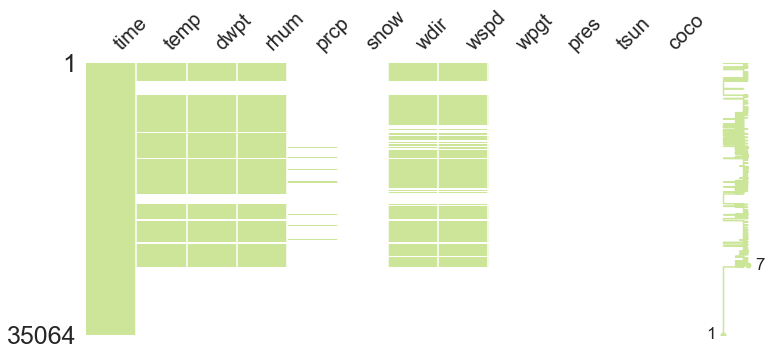

In [165]:
import missingno as msno
%matplotlib inline
msno.matrix(hourly_weather.sort_values('time'), fontsize=20, figsize=(12,5), color=(0.8, 0.9, .6))

# Values are sorted by time, missing values occur at certain times due to outages

#### Missing findings
The hourly weather data have a high degree of missingness.  Temperature (temp), dewpoint (dwpt), and relative humidity (rhum) can be used with confidence. The ppecipitation field can be used, it will be assumed that missing values record 0 precipitation.

Next steps are to subset the columns, clarify names, and check data types.

In [166]:

take_col = ['time', 'temp', 'dwpt', 'rhum', 'prcp']
hourly_weather_sub = pd.DataFrame(hourly_weather, columns=take_col)


#rename columns for clarity
hourly_weather_sub=hourly_weather_sub.rename(columns={"temp": "temp_celsius", "dwpt": "dew_pnt", "rhum": "rel_humidity", "prcp": "prcp_mm"})

#flag missing values to  track imputed rows
# True are measured, false will be imputed later
hourly_weather_sub['temp_celsius_measured']=hourly_weather_sub['temp_celsius'].notna()

hourly_weather_sub['dew_pnt_measured']=hourly_weather_sub['dew_pnt'].notna()

hourly_weather_sub['rel_humidity_measured']=hourly_weather_sub['rel_humidity'].notna()



#add month,week,day for imputing
hourly_weather_sub['month']=hourly_weather_sub['time'].dt.month
hourly_weather_sub['day']=hourly_weather_sub['time'].dt.day
hourly_weather_sub['hour']=hourly_weather_sub['time'].dt.hour

# replace missing precipitation
hourly_weather_sub['prcp_mm'] = hourly_weather_sub['prcp_mm'].fillna(0)


#substitute temperature using mean method.  We will fill other missing values with regression
hourly_weather_sub['temp_celsius'] = hourly_weather_sub.groupby(['month', 'day','hour'])['temp_celsius']\
    .transform(lambda x: x.fillna(x.mean()))

#drop extraneous columns
hourly_weather_sub=hourly_weather_sub.drop(['month', 'day','hour'], axis = 1)


hourly_weather_sub.head()
#hourly_weather_sub.info()



time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2016-01-01 00:00:00         -16.0    -20.0          71.0      0.0   
1 2016-01-01 01:00:00         -16.0    -20.0          71.0      0.0   
2 2016-01-01 02:00:00         -16.0    -20.0          71.0      0.0   
3 2016-01-01 03:00:00         -15.0    -19.9          66.0      0.0   
4 2016-01-01 04:00:00         -16.0    -22.0          60.0      0.0   

   temp_celsius_measured  dew_pnt_measured  rel_humidity_measured  
0                   True              True                   True  
1                   True              True                   True  
2                   True              True                   True  
3                   True              True                   True  
4                   True              True                   True

In [167]:
import plotly.express as px
def custom_legend_name(new_names):
    for i, new_name in enumerate(new_names):
        fig.data[i].name = new_name

fig = px.scatter(x = hourly_weather_sub['time'] ,
              y = hourly_weather_sub['temp_celsius'],
              title = 'Temperature (Celsius) vs. Time',
             color=hourly_weather_sub['temp_celsius_measured'])
custom_legend_name(['measured','mean imputed'])


fig.show()

### Weather Data Replace NA

Now that all rows have a temperature value we will impute an estimate for dew point and relative humidity

In [168]:
#count missing
print(hourly_weather_sub.isnull().sum())

time                         0
temp_celsius                 0
dew_pnt                  12568
rel_humidity             12568
prcp_mm                      0
temp_celsius_measured        0
dew_pnt_measured             0
rel_humidity_measured        0
dtype: int64


In [169]:
# Check to correlation between temperature and the other variables
hourly_weather_sub[["temp_celsius", "dew_pnt", "rel_humidity", "prcp_mm"]].corr()

temp_celsius   dew_pnt  rel_humidity   prcp_mm
temp_celsius      1.000000  0.587528     -0.543202  0.072738
dew_pnt           0.587528  1.000000      0.320253  0.167743
rel_humidity     -0.543202  0.320253      1.000000  0.084968
prcp_mm           0.072738  0.167743      0.084968  1.000000

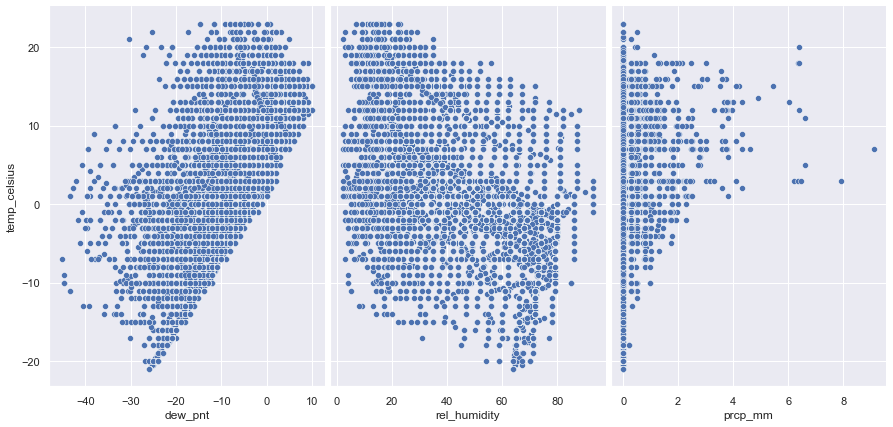

In [170]:
# visualize the relationship between the features and the Temperature (Celsius) using scatterplots
sns.pairplot(hourly_weather_sub, x_vars=['dew_pnt','rel_humidity','prcp_mm'], y_vars='temp_celsius', height=6, aspect=0.7)

## Weather observations

Temperature is positively correlated with dew point and negatively correlated with relative humidity.  Relative humidity is higher in colder weather.  Looking at the Plots this relationship can be observed but there's high variability in the data.  Also, there appears to be a uniform overprint in the relative humidty plot.  This is due to us selecting the normalization and interpolation options when we imported the data.  The source of the weather data already did some interpolation of missing values which is creating the observed trend.  We will fit a linear model to "impute" missing values for relative humidity and dew point.


In [171]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Temperature is the most complete

# create model of dew point given temperature and precipitation
dew_mod = ols("dew_pnt ~ temp_celsius+ prcp_mm+ prcp_mm*temp_celsius", data=hourly_weather_sub).fit()

dew_model_summary = dew_mod.summary()
dew_model_summary



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dew_pnt   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     4214.
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:40:25   Log-Likelihood:                -72600.
No. Observations:               22496   AIC:                         1.452e+05
Df Residuals:                   22492   BIC:                         1.452e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -9.9422      0.043   -229.045      0.000     -10.027      -9.857
temp_celsius             0.4965      0.005    106.660      0.000       0.487       0.506
prcp_mm                  2.3711      0.217     10.940      0.000       1.946       2.796
prcp_mm:temp_celsius     0.0644      0.022      2.994      0.003       0.022       0.107
==============================================================================
Omnibus:                     3772.174   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7281.158
Skew:                          -1.037   Prob(JB):                         0.00
Kurtosis:                       4.862   Cond. No.                         49.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

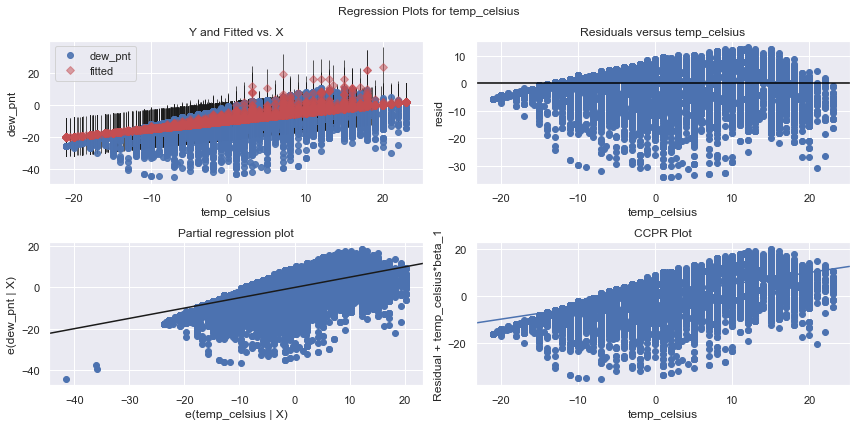

In [172]:
import statsmodels

fig = plt.figure(figsize=(12,6))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(dew_mod, "temp_celsius", fig=fig)

In [173]:
# Create humidity model
# create model of dew point given temperature and precipitation
rel_humid_mod = ols("rel_humidity ~ temp_celsius+ prcp_mm+ prcp_mm*temp_celsius", data=hourly_weather_sub).fit()

rel_humid_summary = rel_humid_mod.summary()
rel_humid_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rel_humidity   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     3401.
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:40:27   Log-Likelihood:                -97205.
No. Observations:               22496   AIC:                         1.944e+05
Df Residuals:                   22492   BIC:                         1.944e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               53.1491      0.130    410.141      0.000      52.895      53.403
temp_celsius            -1.3782      0.014    -99.165      0.000      -1.405      -1.351
prcp_mm                  8.4563      0.647     13.070      0.000       7.188       9.725
prcp_mm:temp_celsius     0.0730      0.064      1.137      0.255      -0.053       0.199
==============================================================================
Omnibus:                      307.235   Durbin-Watson:                   0.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.287
Skew:                          -0.228   Prob(JB):                     2.26e-61
Kurtosis:                       2.701   Cond. No.                         49.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

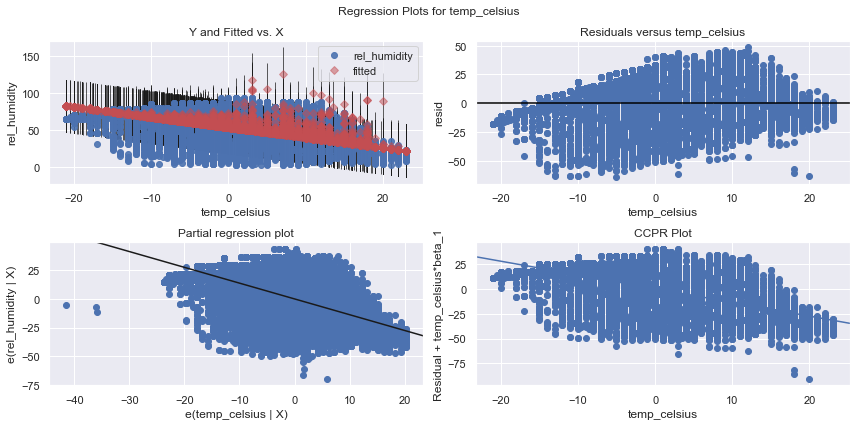

In [174]:
#Evaluate the rel humidity model 
fig = plt.figure(figsize=(12,6))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(rel_humid_mod, "temp_celsius", fig=fig)

In [175]:


# create predictions for dew point and relative humidity

hourly_weather_sub['pred_dwpnt']=dew_mod.predict(hourly_weather_sub)

hourly_weather_sub['pred_rhum']=rel_humid_mod.predict(hourly_weather_sub)


hourly_weather_sub.head()

time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2016-01-01 00:00:00         -16.0    -20.0          71.0      0.0   
1 2016-01-01 01:00:00         -16.0    -20.0          71.0      0.0   
2 2016-01-01 02:00:00         -16.0    -20.0          71.0      0.0   
3 2016-01-01 03:00:00         -15.0    -19.9          66.0      0.0   
4 2016-01-01 04:00:00         -16.0    -22.0          60.0      0.0   

   temp_celsius_measured  dew_pnt_measured  rel_humidity_measured  pred_dwpnt  \
0                   True              True                   True  -17.886766   
1                   True              True                   True  -17.886766   
2                   True              True                   True  -17.886766   
3                   True              True                   True  -17.390228   
4                   True              True                   True  -17.886766   

   pred_rhum  
0  75.200258  
1  75.200258  
2  75.200258  
3  73.822062  
4  75.200258

<AxesSubplot:xlabel='pred_dwpnt', ylabel='dew_pnt'>

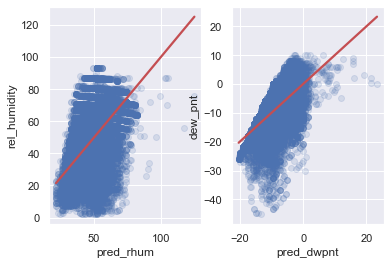

In [176]:
#Create Predicted vs actual plotfor relative humidity (left) and dew point (right)

fig, ax =plt.subplots(1,2)

sns.regplot(x='pred_rhum', y='rel_humidity', data=hourly_weather_sub, line_kws = {"color":"r"}, 
            ci=None,scatter_kws={'alpha':0.15},ax=ax[0])

sns.regplot(x='pred_dwpnt', y='dew_pnt', data=hourly_weather_sub, line_kws = {"color":"r"},
            scatter_kws={'alpha':0.15}, ci=None,ax=ax[1] )



In [177]:


#fill missing rel humidity values with predictions
hourly_weather_sub['dew_pnt'] = hourly_weather_sub['dew_pnt'].fillna(hourly_weather_sub['pred_dwpnt'])

# fill missing dew point values with predictions
hourly_weather_sub['rel_humidity'] = hourly_weather_sub['rel_humidity'].fillna(hourly_weather_sub['pred_rhum'])

#take relevant columns
hourly_weather_final = hourly_weather_sub.drop(['pred_dwpnt', 'pred_rhum','dew_pnt_measured','rel_humidity_measured'], axis = 1)


#print 
hourly_weather_final.head()


time  temp_celsius  dew_pnt  rel_humidity  prcp_mm  \
0 2016-01-01 00:00:00         -16.0    -20.0          71.0      0.0   
1 2016-01-01 01:00:00         -16.0    -20.0          71.0      0.0   
2 2016-01-01 02:00:00         -16.0    -20.0          71.0      0.0   
3 2016-01-01 03:00:00         -15.0    -19.9          66.0      0.0   
4 2016-01-01 04:00:00         -16.0    -22.0          60.0      0.0   

   temp_celsius_measured  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True

In [178]:
#Check for complete data

print("Missing values post imputation")
print(hourly_weather_final.isnull().sum())



Missing values post imputation
time                     0
temp_celsius             0
dew_pnt                  0
rel_humidity             0
prcp_mm                  0
temp_celsius_measured    0
dtype: int64


## Combine Hourly Traffic and weather data

In [179]:
hourly_data_combined =pd.merge(
                   hourly_traffic_full,
                   hourly_weather_final,
                   how="left",
                   left_on=['count_datetime'],
                   right_on=['time']
)
#drop 
hourly_data_combined=hourly_data_combined.drop(['time'], axis = 1)

#rearrange columns
cols = hourly_data_combined.columns.tolist()
cols = ['count_date',
    'count_datetime',
    'direction',
    'month',
    'week',
    'hour',
    'vehicles_per_hour',
    'temp_celsius',
    'dew_pnt',
    'rel_humidity',
    'prcp_mm',
     'measured',
    'temp_celsius_measured']

hourly_data_combined = hourly_data_combined[cols]
# print first few rows
hourly_data_combined.head()



count_date      count_datetime direction  month  week  hour  \
0 2016-01-01 2016-01-01 00:00:00         P      1    53     0   
1 2016-01-01 2016-01-01 00:00:00         S      1    53     0   
2 2016-01-01 2016-01-01 01:00:00         P      1    53     1   
3 2016-01-01 2016-01-01 01:00:00         S      1    53     1   
4 2016-01-01 2016-01-01 02:00:00         P      1    53     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               65.0         -16.0    -20.0          71.0      0.0      True   
1              115.0         -16.0    -20.0          71.0      0.0      True   
2               71.0         -16.0    -20.0          71.0      0.0      True   
3              118.0         -16.0    -20.0          71.0      0.0      True   
4               64.0         -16.0    -20.0          71.0      0.0      True   

   temp_celsius_measured  
0                   True  
1                   True  
2                   True  
3                   True  
4                   True

In [180]:
print("Missing values post imputation")
print(hourly_data_combined.isnull().sum())

Missing values post imputation
count_date               0
count_datetime           0
direction                0
month                    0
week                     0
hour                     0
vehicles_per_hour        0
temp_celsius             0
dew_pnt                  0
rel_humidity             0
prcp_mm                  0
measured                 0
temp_celsius_measured    0
dtype: int64


## Add descriptive columns



In [181]:
# calculate the day of the year for time_series plots
hourly_data_combined['day_of_year'] = hourly_data_combined['count_date'].dt.dayofyear

#calculate day of week number (0 = Monday, 6= Sunday)
hourly_data_combined['day_of_week']=hourly_data_combined['count_date'].dt.day_of_week

# designate weekend ()
hourly_data_combined.loc[hourly_data_combined['day_of_week'] >=5, 'weekend'] = 1 
hourly_data_combined.loc[hourly_data_combined['day_of_week'] <5, 'weekend'] = 0 


# mark American holidays. Note that holidays that fall on weekedns are applied in the preceding or proceeding week.
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=hourly_data_combined['count_date'].min(),
                        end=hourly_data_combined['count_date'].max()).to_pydatetime()

#designate which days are holidays
hourly_data_combined['holiday'] = hourly_data_combined['count_date'].isin(holidays)


#check that tables look good by printing the first few rows.
hourly_data_combined.head()




count_date      count_datetime direction  month  week  hour  \
0 2016-01-01 2016-01-01 00:00:00         P      1    53     0   
1 2016-01-01 2016-01-01 00:00:00         S      1    53     0   
2 2016-01-01 2016-01-01 01:00:00         P      1    53     1   
3 2016-01-01 2016-01-01 01:00:00         S      1    53     1   
4 2016-01-01 2016-01-01 02:00:00         P      1    53     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               65.0         -16.0    -20.0          71.0      0.0      True   
1              115.0         -16.0    -20.0          71.0      0.0      True   
2               71.0         -16.0    -20.0          71.0      0.0      True   
3              118.0         -16.0    -20.0          71.0      0.0      True   
4               64.0         -16.0    -20.0          71.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            4      0.0     True  
1                   True            1            4      0.0     True  
2                   True            1            4      0.0     True  
3                   True            1            4      0.0     True  
4                   True            1            4      0.0     True

In [182]:
#identify a random date, filter to date of interest, pull the whole week
import datetime as dt
from datetime import timedelta
import random

# select a random date, plot vehicle counts for that day.
min_date= hourly_data_combined['count_date'].min()
max_date= hourly_data_combined['count_date'].max()


#set seed
random.seed(12)

#get random date between the min and max for the dataset 
time_between_dates = max_date - min_date
days_between_dates = time_between_dates.days
random_number_of_days = random.randrange(days_between_dates)
random_date = min_date + timedelta(days=random_number_of_days)

#random day in the data
random_date

#get day of week, create lower and upper bound for filter to 1 random week
#Monday is 0, Sunday is 6
random_day_of_week=  random_date.day_of_week
day_to_add= 6-random_day_of_week
day_to_sub= 0+random_day_of_week
#
#day_to_add
#day_to_sub


#create lower and upper bound filter
upper_bound= random_date + timedelta(days=day_to_add)
#upper_bound

lower_bound= random_date - timedelta(days=day_to_sub)
#lower_bound

#set mask for date filter
mask = (hourly_data_combined['count_date'] >= lower_bound) & (hourly_data_combined['count_date'] <= upper_bound)

#filter data to 1 random week
#print("The first table is for one week that contains our random day ")
one_week = hourly_data_combined.loc[mask]
#print(one_week.head())
#print(one_week.shape)

#filter data to 1 random day
print("The second tables is for one random day ")
one_day= hourly_data_combined.loc[hourly_data_combined['count_date'] == random_date]

one_day.head()

The second tables is for one random day 


count_date      count_datetime direction  month  week  hour  \
46608 2018-08-29 2018-08-29 00:00:00         P      8    35     0   
46609 2018-08-29 2018-08-29 00:00:00         S      8    35     0   
46610 2018-08-29 2018-08-29 01:00:00         P      8    35     1   
46611 2018-08-29 2018-08-29 01:00:00         S      8    35     1   
46612 2018-08-29 2018-08-29 02:00:00         P      8    35     2   

       vehicles_per_hour  temp_celsius   dew_pnt  rel_humidity  prcp_mm  \
46608              110.0     11.333333 -4.314728     37.529558      0.0   
46609              153.0     11.333333 -4.314728     37.529558      0.0   
46610               73.0     11.500000 -4.231972     37.299858      0.0   
46611              104.0     11.500000 -4.231972     37.299858      0.0   
46612               70.0     10.000000 -4.976779     39.367153      0.0   

       measured  temp_celsius_measured  day_of_year  day_of_week  weekend  \
46608      True                  False          241            2      0.0   
46609      True                  False          241            2      0.0   
46610      True                  False          241            2      0.0   
46611      True                  False          241            2      0.0   
46612      True                  False          241            2      0.0   

       holiday  
46608    False  
46609    False  
46610    False  
46611    False  
46612    False

### Create Plots to examine daily and weekly trends

Now that the data are mined and confirmed to be in good order with minimal missingness we want to get  a feel for any cyclicity in the data.  Traffic counts are a product of road usage.  Given the location of the Eisehower tunnel we will geta  good sense of when people are accessing the mountains.  I70 is a busy interstate and through traffic will be a major component of daily use; however, residents of the front range will drive through the tunnel to access mountain recreation.  We should then expect heavy usage during certain seasons, weekends, and holidays.  We will now examine a random day and random week for patterns in the data.  We will include direction to get a feel for when day-trippers may be returning home from the mountains.


This is a  daily plot for a  random day with direction 


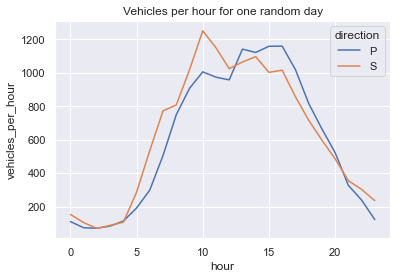

In [183]:
# Daily Plot

print("This is a  daily plot for a  random day with direction ")
sns.lineplot(data=one_day, x="hour", y="vehicles_per_hour", hue="direction").set(
    title="Vehicles per hour for one random day")

sns.set(rc = {'figure.figsize':(10,8)})

In [184]:
# weekly plot random week

#Plot traffic counts vs date 
import plotly.express as px


fig = px.line( x = one_week['count_datetime'] ,
              y = one_week['vehicles_per_hour'],
              color=one_week['direction'],
              title = 'Daily Traffic Counts for a Random  Week')
fig.show()

The patterns observed in this random week from monday to Sunday are typical.  Traffic directions, indicated as "primary" and "secondary" refer to east and westbound traffic respectively.  Resident on the front Range drive west (secondary, "s") to access the mountains.  Each day westward traffic spike around 8 AM and eastbound traffic peaks in the PM.  There is elevated westward traffic on Friday and a large influx Sunday afternoon.
Next we will generate daily totals for all days in the data set.  We will also identify days that fall on weekedns and holidays.



# Data Exploration

## Questions to be considered

1) When is traffic the heaviest?
2) On average what is the busiest day of the week?
3) How does East and West Traffic compare?
4) What is the effect of holidays on traffic counts?
5) What is the effect of precipitation on traffic counts?
6) What are the total traffic counts for each year? What are the trends?
7) Which months and days have the highest traffic counts?
8) What was the impact of the 2020 pandemic on traffic counts?



In [185]:
#ax = sns.heatmap(df, cmap='RdYlGn_r',
#                 robust=True,
#                 fmt='.2f',
#                 annot=True,
#                 linewidths=.5,
#                 annot_kws={'size':11},
#                 cbar_kws={'shrink':.8,
#                           'label':'Precipitation(mm)'})                       
#    
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
#plt.title('Average Precipitations', fontdict={'fontsize':18},    pad=14);

In [186]:
# Check out a correlation plot.  If vehicles per hour is our desired response variable, non of the independent vairables have a strong linear relationship

hourly_data_combined[["vehicles_per_hour","day_of_week","day_of_year", "hour","temp_celsius", "dew_pnt", "rel_humidity", "prcp_mm"]].corr()

vehicles_per_hour   day_of_week   day_of_year  \
vehicles_per_hour           1.000000  1.894531e-01 -2.328556e-02   
day_of_week                 0.189453  1.000000e+00  6.509521e-03   
day_of_year                -0.023286  6.509521e-03  1.000000e+00   
hour                        0.293284  2.383128e-17 -3.057455e-15   
temp_celsius               -0.002117  4.894125e-03  2.083153e-01   
dew_pnt                     0.016736 -4.112126e-03  1.648678e-01   
rel_humidity                0.008812 -7.101597e-03 -9.082389e-02   
prcp_mm                    -0.021845 -3.552883e-03  1.598842e-02   

                           hour  temp_celsius   dew_pnt  rel_humidity  \
vehicles_per_hour  2.932842e-01     -0.002117  0.016736      0.008812   
day_of_week        2.383128e-17      0.004894 -0.004112     -0.007102   
day_of_year       -3.057455e-15      0.208315  0.164868     -0.090824   
hour               1.000000e+00      0.090954  0.004715     -0.107339   
temp_celsius       9.095361e-02      1.000000  0.660390     -0.621229   
dew_pnt            4.714959e-03      0.660390  1.000000      0.143550   
rel_humidity      -1.073385e-01     -0.621229  0.143550      1.000000   
prcp_mm            6.780921e-02      0.072646  0.159649      0.076857   

                    prcp_mm  
vehicles_per_hour -0.021845  
day_of_week       -0.003553  
day_of_year        0.015988  
hour               0.067809  
temp_celsius       0.072646  
dew_pnt            0.159649  
rel_humidity       0.076857  
prcp_mm            1.000000

In [187]:
# time and day trends
# get the mean for the data by hour and day

#hourly_data_combined_heat  =  hourly_data_combined[['vehicles_per_hour','month', 'day_of_week', 'hour']]


hourly_data_combined.head()

count_date      count_datetime direction  month  week  hour  \
0 2016-01-01 2016-01-01 00:00:00         P      1    53     0   
1 2016-01-01 2016-01-01 00:00:00         S      1    53     0   
2 2016-01-01 2016-01-01 01:00:00         P      1    53     1   
3 2016-01-01 2016-01-01 01:00:00         S      1    53     1   
4 2016-01-01 2016-01-01 02:00:00         P      1    53     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               65.0         -16.0    -20.0          71.0      0.0      True   
1              115.0         -16.0    -20.0          71.0      0.0      True   
2               71.0         -16.0    -20.0          71.0      0.0      True   
3              118.0         -16.0    -20.0          71.0      0.0      True   
4               64.0         -16.0    -20.0          71.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            4      0.0     True  
1                   True            1            4      0.0     True  
2                   True            1            4      0.0     True  
3                   True            1            4      0.0     True  
4                   True            1            4      0.0     True

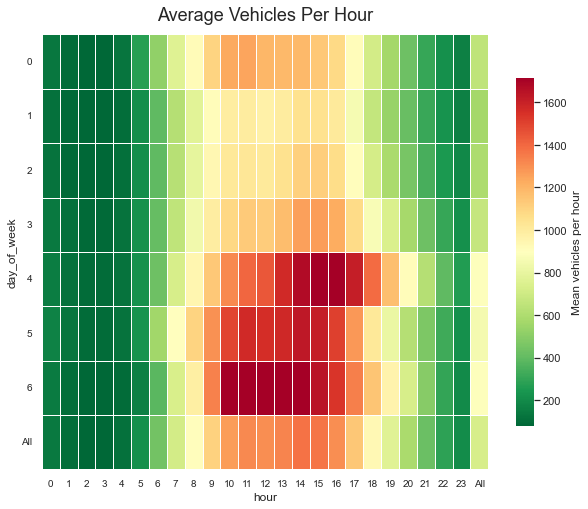

In [188]:
#Get averages by day of week and time

all_hours_day_df = pd.pivot_table(data= hourly_data_combined[['vehicles_per_hour', 'day_of_week', 'hour']], 
                                  values="vehicles_per_hour",
                                   index="day_of_week",
                                  columns="hour",
                                  margins=True
                                   )
#print(all_hours_day_df.head(7))


ax = sns.heatmap(all_hours_day_df, cmap='RdYlGn_r',
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Vehicles Per Hour', fontdict={'fontsize':18},    pad=14);

#type(hourly_data_combined_heat)

The heat map above has the average traffic counts for Eisenhower tunnel for both the East and West bound lanes combined.  The pattern is clear, the 5-6 (0 index) days of the week, Friday-Sunday have the highest traffic counts.  The average values for Sunday afternoon are > 1600 cars per hour, or 1 car every 2 seconds.  Next we will examine the average effects between each month. 

In [189]:
#divide data into east and westbound
#compare Primary  and Secondary
hourly_data_combined_primary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['P'])]
all_hours_day_df_primary = pd.pivot_table(data= hourly_data_combined_primary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )
#all_hours_day_df_primary.head()




#compare Primary  and Secondary
hourly_data_combined_secondary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['S'])]
all_hours_day_df_secondary = pd.pivot_table(data= hourly_data_combined_secondary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )
#all_hours_day_df_secondary.head()
hourly_data_combined_secondary = hourly_data_combined.loc[hourly_data_combined['direction'].isin(['S'])]
all_hours_day_df_secondary = pd.pivot_table(data= hourly_data_combined_secondary[['vehicles_per_hour', 'day_of_week', 'hour','direction']], 
                                  values="vehicles_per_hour",
                                   index=["day_of_week"],
                                  columns="hour",
                                  margins=True
                                   )


hourly_data_combined_secondary.head(3)




count_date      count_datetime direction  month  week  hour  \
1 2016-01-01 2016-01-01 00:00:00         S      1    53     0   
3 2016-01-01 2016-01-01 01:00:00         S      1    53     1   
5 2016-01-01 2016-01-01 02:00:00         S      1    53     2   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
1              115.0         -16.0    -20.0          71.0      0.0      True   
3              118.0         -16.0    -20.0          71.0      0.0      True   
5               99.0         -16.0    -20.0          71.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
1                   True            1            4      0.0     True  
3                   True            1            4      0.0     True  
5                   True            1            4      0.0     True

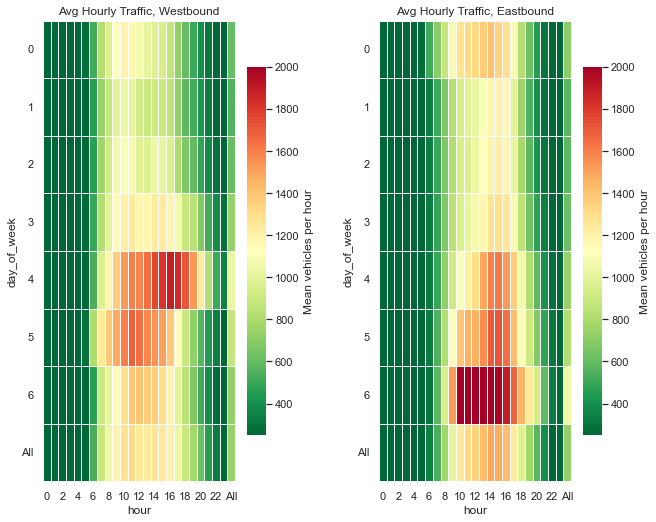

In [190]:

#
#Color maps comparing east and westbound traffic

import numpy as np; np.random.seed(0)
import seaborn as sns

#all_hours_day_df_secondary   
#all_hours_day_df_primary 

fig, ax =plt.subplots(1,2)

sns.heatmap(all_hours_day_df_secondary, ax=ax[0],cmap='RdYlGn_r',
                 robust=True,
                 vmin=250,
                 vmax=2000,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})
sns.heatmap(all_hours_day_df_primary, ax=ax[1],cmap='RdYlGn_r',
             vmin=250,
                 vmax=2000,
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'}           
           )
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
ax[0].title.set_text('Avg Hourly Traffic, Westbound')
ax[1].title.set_text('Avg Hourly Traffic, Eastbound')
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0, fontsize=11)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0, fontsize=11)
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0, fontsize=11)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0, fontsize=11)
sns.set(rc = {'figure.figsize':(21,8)})
plt.show()

Two heatmaps showing the average traffic count for each hour on each day of the week.  Traffic counts are highest 7:00-6:00 on each day of the week.  Westbound traffic is heavier earlier in the day than eastbound traffic.  The heaviest westbound traffic is on Friday and Saturday, the highest eastbound traffic is on Sunday as commuters return to Denver.

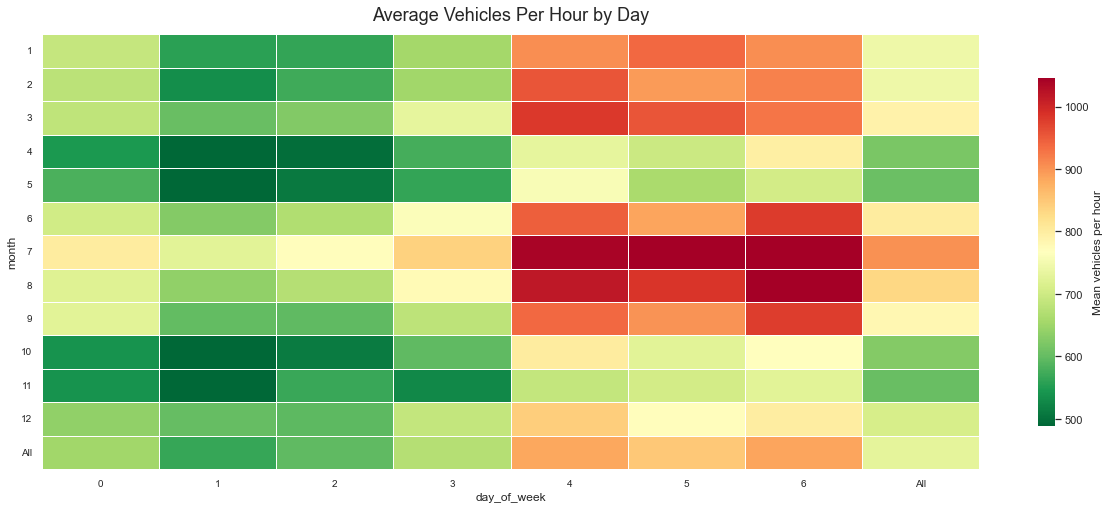

In [191]:
#Get averages by day of week and time

all_months_weeks = pd.pivot_table(data= hourly_data_combined[['vehicles_per_hour', 'month', 'day_of_week']], 
                                  values="vehicles_per_hour",
                                   index="month",
                                  columns="day_of_week",
                                  margins=True
                                   )
#print(all_hours_day_df.head(7))


ax = sns.heatmap(all_months_weeks, cmap='RdYlGn_r',
                
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'Mean vehicles per hour'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Vehicles Per Hour by Day', fontdict={'fontsize':18},    pad=14);


#type(hourly_data_combined_heat)

The heat map shows the average hourly traffic counts by month for each day of the week.  The averages are much lower than those above because the daily values include all of the low traffic hours in the early morning.  Friday through Sunday are high traffic days in nearly every month.  Traffic is elevated during the ski season, January-March, and during the Summer.  Interestingly the week of fourth of July sees elevated traffic on weekdays.  This is likely due to when the July 4th holiday falls in a given year.  Overall Winter and Summer have the most traffic with reduced traffic in the Fall and Spring.  Traffic is higher in the fall than in the spring.  On average the best day and month to travel is a Tuesday in April or May. One would expect very high traffic on a Saturday afternoon in July.

### Daily totals


In [192]:
hourly_data_combined.head(2)



count_date count_datetime direction  month  week  hour  vehicles_per_hour  \
0 2016-01-01     2016-01-01         P      1    53     0               65.0   
1 2016-01-01     2016-01-01         S      1    53     0              115.0   

   temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0         -16.0    -20.0          71.0      0.0      True   
1         -16.0    -20.0          71.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            4      0.0     True  
1                   True            1            4      0.0     True

In [193]:
#compile data to the day.  

fixed_values= hourly_data_combined[["count_date", "month", "week",  "measured",'direction', "temp_celsius_measured", "day_of_week", "weekend", "holiday"]]
fixed_values=fixed_values.drop_duplicates(subset=['count_date', 'direction'], keep='last')


#values to sum
day_values_sum = hourly_data_combined[["count_date", "vehicles_per_hour", "direction","prcp_mm"  ]]
daily_traffic  =  day_values_sum.groupby(['count_date', 'direction']).sum()
daily_traffic=daily_traffic.rename(columns={"vehicles_per_hour": "vehicles_per_day"})



# columns to mean
day_values_mean = hourly_data_combined[["count_date",  "temp_celsius",  "dew_pnt" , "rel_humidity"]]
day_values_mean=day_values_mean.groupby('count_date').mean()

#join sums and fixed header data
daily_data_combined= pd.merge(
    daily_traffic,
    fixed_values,
    how='left',
    on= ['count_date','direction']

)
#
# add pertinent headers
daily_data_combined['day_of_year'] = daily_data_combined['count_date'].dt.dayofyear
daily_data_combined['year'] = daily_data_combined['count_date'].dt.year


daily_data_combined= pd.merge(
    daily_data_combined,
    day_values_mean,
    how='left',
    on= ['count_date']

)


#join with mean data

print(daily_data_combined.shape)
daily_data_combined.head()


(2920, 16)


count_date direction  vehicles_per_day  prcp_mm  month  week  measured  \
0 2016-01-01         P           21272.0      1.8      1    53      True   
1 2016-01-01         S           19947.0      1.8      1    53      True   
2 2016-01-02         P           30650.0      2.4      1    53      True   
3 2016-01-02         S           20788.0      2.4      1    53      True   
4 2016-01-03         P           26556.0      0.0      1    53      True   

   temp_celsius_measured  day_of_week  weekend  holiday  day_of_year  year  \
0                   True            4      0.0     True            1  2016   
1                   True            4      0.0     True            1  2016   
2                   True            5      1.0    False            2  2016   
3                   True            5      1.0    False            2  2016   
4                   True            6      1.0    False            3  2016   

   temp_celsius    dew_pnt  rel_humidity  
0    -11.625000 -28.206250     30.000000  
1    -11.625000 -28.206250     30.000000  
2     -5.750000 -23.727829     32.668744  
3     -5.750000 -23.727829     32.668744  
4     -3.666667 -15.839583     39.062500

In [194]:
daily_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 0 to 2919
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   count_date             2920 non-null   datetime64[ns]
 1   direction              2920 non-null   object        
 2   vehicles_per_day       2920 non-null   float64       
 3   prcp_mm                2920 non-null   float64       
 4   month                  2920 non-null   int64         
 5   week                   2920 non-null   UInt32        
 6   measured               2920 non-null   bool          
 7   temp_celsius_measured  2920 non-null   bool          
 8   day_of_week            2920 non-null   int64         
 9   weekend                2920 non-null   float64       
 10  holiday                2920 non-null   bool          
 11  day_of_year            2920 non-null   int64         
 12  year                   2920 non-null   int64         
 13  tem

In [195]:
# Plot time series of all data

#Plot Temperature vs date 
import plotly.express as px


fig = px.line( x = daily_data_combined['count_date'] ,
              y = daily_data_combined['vehicles_per_day'],
              color=daily_data_combined['direction'],
              title = 'Daily Traffic Counts for years of interest')
fig.show()

<AxesSubplot:xlabel='day_of_year', ylabel='vehicles_per_day'>

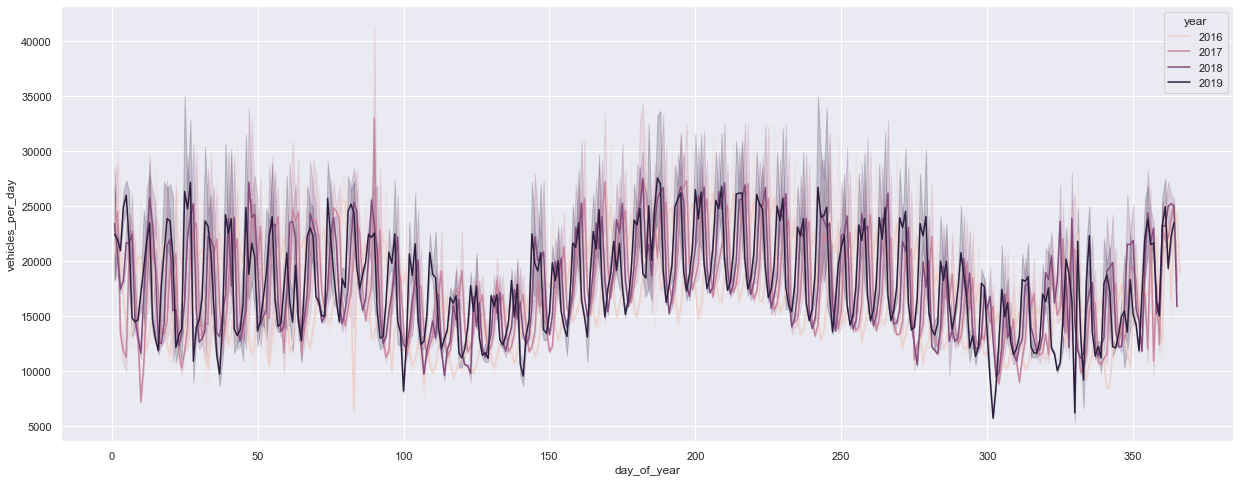

In [196]:
# get value counts for each year.
#Plot standardized to day of year Broken out by year
sns.lineplot(data=daily_data_combined, x="day_of_year", y="vehicles_per_day", hue="year")


In [197]:
# totals regardless of direction

daily_totals= daily_data_combined[["day_of_year","vehicles_per_day","year"]]
daily_totals = daily_totals.groupby(["year", "day_of_year"]).sum()
daily_totals.head()


vehicles_per_day
year day_of_year                  
2016 1                     41219.0
     2                     51438.0
     3                     44889.0
     4                     33971.0
     5                     26904.0

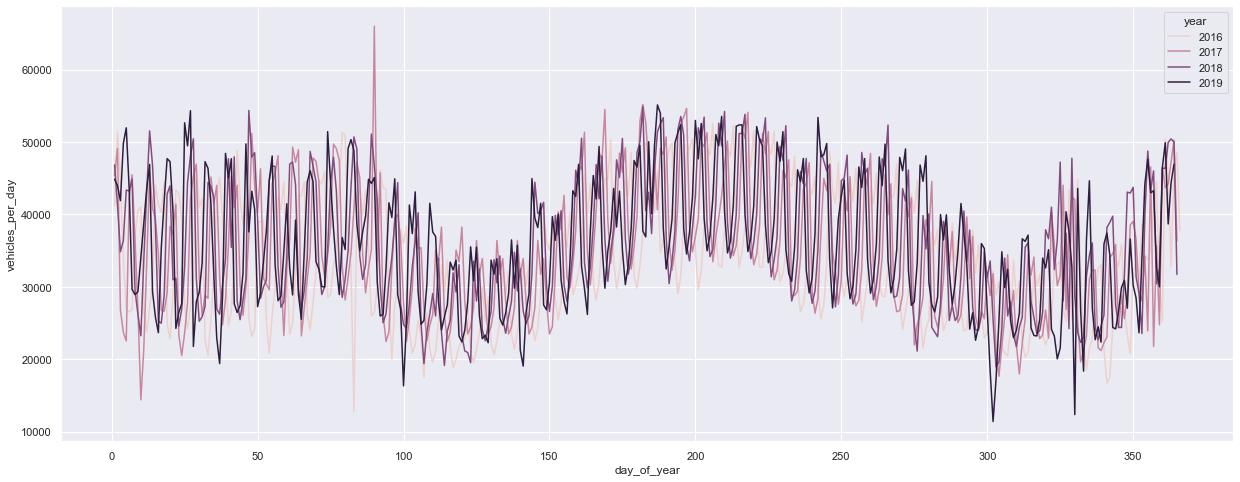

In [198]:
sns.lineplot(data=daily_totals, x="day_of_year", y="vehicles_per_day", hue="year")
sns.set(rc = {'figure.figsize':(16,5)})

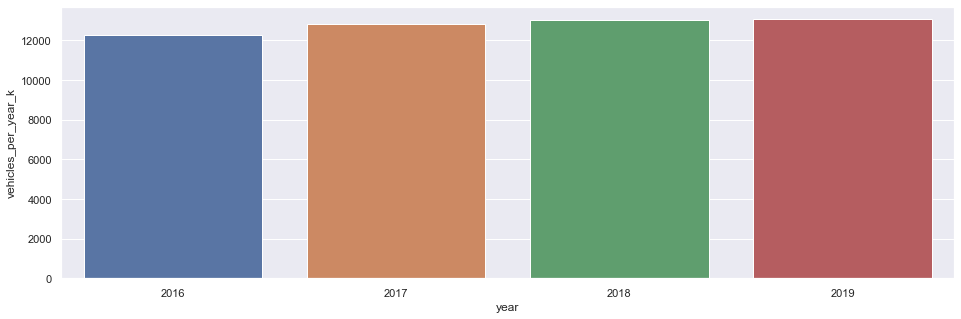

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt

yearly_totals= daily_data_combined[[ 'vehicles_per_day','year' ]]
yearly_totals = yearly_totals.groupby('year').sum()/1000

yearly_totals=yearly_totals.rename(columns={"vehicles_per_day": "vehicles_per_year_k"})
yearly_totals.head()

#
# barplot annual totals
sns.barplot(x = yearly_totals.index,
            y = yearly_totals['vehicles_per_year_k'])
 
sns.set(rc = {'figure.figsize':(8,4)})

## Explore weather data

Take mean for each hour and compare against that hour relative based on precipitation.




In [200]:
hourly_data_combined.head(4)

count_date      count_datetime direction  month  week  hour  \
0 2016-01-01 2016-01-01 00:00:00         P      1    53     0   
1 2016-01-01 2016-01-01 00:00:00         S      1    53     0   
2 2016-01-01 2016-01-01 01:00:00         P      1    53     1   
3 2016-01-01 2016-01-01 01:00:00         S      1    53     1   

   vehicles_per_hour  temp_celsius  dew_pnt  rel_humidity  prcp_mm  measured  \
0               65.0         -16.0    -20.0          71.0      0.0      True   
1              115.0         -16.0    -20.0          71.0      0.0      True   
2               71.0         -16.0    -20.0          71.0      0.0      True   
3              118.0         -16.0    -20.0          71.0      0.0      True   

   temp_celsius_measured  day_of_year  day_of_week  weekend  holiday  
0                   True            1            4      0.0     True  
1                   True            1            4      0.0     True  
2                   True            1            4      0.0     True  
3                   True            1            4      0.0     True

In [201]:
# means for hour and direction
hour_values_mean = hourly_data_combined[["day_of_year","hour",  "direction",   "vehicles_per_hour", "prcp_mm" ]]
hour_values_mean=hour_values_mean.groupby(["day_of_year", "hour",  "direction"]).mean()

#rename columns
hour_values_mean=hour_values_mean.rename(columns={"vehicles_per_hour": "mean_vehicles_per_hour", "prcp_mm": "mean_prcp_mm"})
hour_values_mean.head(4)



mean_vehicles_per_hour  mean_prcp_mm
day_of_year hour direction                                      
1           0    P                           80.75           0.0
                 S                           86.50           0.0
            1    P                           72.00           0.0
                 S                           97.25           0.0

In [202]:

#join mean to hourly data, 
#hourly_data_combined_
hourly_data_combined_mean = pd.merge(
                   hourly_data_combined,
                   hour_values_mean,
                    how='left',
                    on=['day_of_year', 'hour', 'direction']

)


#new_df = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])

hourly_data_combined_mean.head()



hourly_data_combined_mean_pcp= hourly_data_combined_mean[["count_date", "count_datetime", "direction","prcp_mm", "vehicles_per_hour","mean_vehicles_per_hour"]]

hourly_data_combined_mean_pcp["veh_diff_from_mean_prcnt"]=(hourly_data_combined_mean_pcp["vehicles_per_hour"]- hourly_data_combined_mean_pcp["mean_vehicles_per_hour"])/hourly_data_combined_mean_pcp["mean_vehicles_per_hour"]




C:\Users\ckitc\AppData\Local\Temp\ipykernel_24088\2157022918.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



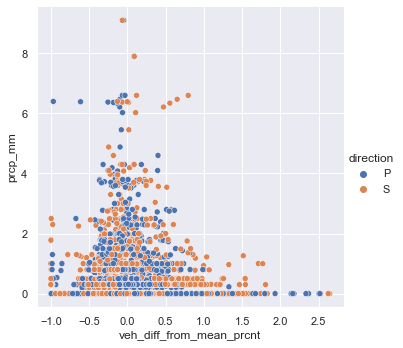

In [203]:
sns.relplot(
    data=hourly_data_combined_mean_pcp, x="veh_diff_from_mean_prcnt", y="prcp_mm", hue='direction'
)

The plot above compares the difference relative to the mean for each tunnel direction.  

Filter out Spring 2020, imputed rows, hours with 0 precipitation, plot as box or histogram

There may be a difference by direction.  Primary is east, west is secondary.
Values are lower than the mean for secondary count.  This could be that fewer people drive during storms or that the weather data west of the tunnel has preipitation on one side of the divide and not the other.

### Prepare Data for initial modelling
The hourly traffic data are imputed and merged with weather data. For our next steps we will create dummy variables for categorical variables, remove irrelevant features, standardize predictor variables, and divide the training data into test train sets.

In [204]:
hourly_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70080 entries, 0 to 70079
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   count_date             70080 non-null  datetime64[ns]
 1   count_datetime         70080 non-null  datetime64[ns]
 2   direction              70080 non-null  object        
 3   month                  70080 non-null  int64         
 4   week                   70080 non-null  UInt32        
 5   hour                   70080 non-null  int64         
 6   vehicles_per_hour      70080 non-null  float64       
 7   temp_celsius           70080 non-null  float64       
 8   dew_pnt                70080 non-null  float64       
 9   rel_humidity           70080 non-null  float64       
 10  prcp_mm                70080 non-null  float64       
 11  measured               70080 non-null  bool          
 12  temp_celsius_measured  70080 non-null  bool          
 13  d

In [205]:
# categorical variables to convert to dummy variables:
#direction

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(), ['direction']),
    remainder='passthrough')

transformed = transformer.fit_transform(hourly_data_combined)
hourly_data_processed = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)


In [206]:
hourly_data_processed.head(2)

onehotencoder__x0_P onehotencoder__x0_S count_date count_datetime month  \
0                 1.0                 0.0 2016-01-01     2016-01-01     1   
1                 0.0                 1.0 2016-01-01     2016-01-01     1   

  week hour vehicles_per_hour temp_celsius dew_pnt rel_humidity prcp_mm  \
0   53    0              65.0        -16.0   -20.0         71.0     0.0   
1   53    0             115.0        -16.0   -20.0         71.0     0.0   

  measured temp_celsius_measured day_of_year day_of_week weekend holiday  
0     True                  True           1           4     0.0    True  
1     True                  True           1           4     0.0    True

In [207]:

#convert boolean to 0 or 1
# drop one hot encoder
#drop irrelevant columns
hourly_data_processed=hourly_data_processed.drop(['onehotencoder__x0_S', 'count_date',
                            'day_of_year','week', 'temp_celsius_measured',
                           'measured','weekend'
                           ], axis = 1)
hourly_data_processed.set_index('count_datetime', inplace=True)

hourly_data_processed["holiday"] = hourly_data_processed["holiday"].astype(int)

In [208]:
hourly_data_processed.head()

onehotencoder__x0_P month hour vehicles_per_hour  \
count_datetime                                                         
2016-01-01 00:00:00                 1.0     1    0              65.0   
2016-01-01 00:00:00                 0.0     1    0             115.0   
2016-01-01 01:00:00                 1.0     1    1              71.0   
2016-01-01 01:00:00                 0.0     1    1             118.0   
2016-01-01 02:00:00                 1.0     1    2              64.0   

                    temp_celsius dew_pnt rel_humidity prcp_mm day_of_week  \
count_datetime                                                              
2016-01-01 00:00:00        -16.0   -20.0         71.0     0.0           4   
2016-01-01 00:00:00        -16.0   -20.0         71.0     0.0           4   
2016-01-01 01:00:00        -16.0   -20.0         71.0     0.0           4   
2016-01-01 01:00:00        -16.0   -20.0         71.0     0.0           4   
2016-01-01 02:00:00        -16.0   -20.0         71.0     0.0           4   

                     holiday  
count_datetime                
2016-01-01 00:00:00        1  
2016-01-01 00:00:00        1  
2016-01-01 01:00:00        1  
2016-01-01 01:00:00        1  
2016-01-01 02:00:00        1

In [209]:
### Split into Test train and Standardize

In [210]:
hourly_data_processed_P= hourly_data_processed.loc[
    (hourly_data_processed.onehotencoder__x0_P == 1)
] 

In [211]:
# get features and respoinse variables

y = hourly_data_processed_P.vehicles_per_hour
X = hourly_data_processed_P.drop(['vehicles_per_hour'],axis=1)

In [212]:
# split into test train.
# time series should not be randomly sampled.  Holding out 1 year worth of rows
test_rows = 365*48 # 365 days, 24 hours, 2 directions. Hold out 1 year of data

X_train = X[:-test_rows]
X_test = X[-test_rows:]

y_train = y[:-test_rows]
y_test = y[-test_rows:]


In [213]:
# Standardize features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# transform data
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [214]:
# get sample dimensions
print("Train")
print(X_train.shape)
print("Test")
print(X_test.shape)


Train
(17520, 9)
Test
(17520, 9)


In [215]:
# This portion concludes the pre-modelling data-munge.

## Modelling
Proposed Workflow:  
ARIMA model
Random Forest (random grid search)
Feature Engineering

In [216]:
hourly_data_processed.head(2)

onehotencoder__x0_P month hour vehicles_per_hour temp_celsius  \
count_datetime                                                                 
2016-01-01                     1.0     1    0              65.0        -16.0   
2016-01-01                     0.0     1    0             115.0        -16.0   

               dew_pnt rel_humidity prcp_mm day_of_week  holiday  
count_datetime                                                    
2016-01-01       -20.0         71.0     0.0           4        1  
2016-01-01       -20.0         71.0     0.0           4        1

### Time Series Analysis

In [217]:
# Filter down to one traffic direction.
# We may experiemnt with both
hourly_data_processed_P= hourly_data_processed.loc[
    (hourly_data_processed.onehotencoder__x0_P == 1)
] 



In [218]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

# test if our time series is stationary
result = adfuller(hourly_data_processed_P.vehicles_per_hour.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("p value <.05 allows us to reject the null hypothesis and conclude the time series is stationary")

ADF Statistic: -20.153026
p-value: 0.000000
p value <.05 allows us to reject the null hypothesis and conclude the time series is stationary


The P value is well below .05, we reject the null hypothesis and conclude that the time series is stationary. We don't need to calulate a difference model for our data.

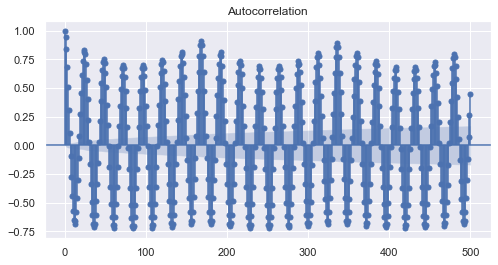

In [219]:
# create autocorrelation for traffic data

#filter to "primary" direction

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(hourly_data_processed_P.vehicles_per_hour, lags=500)
plt.show()

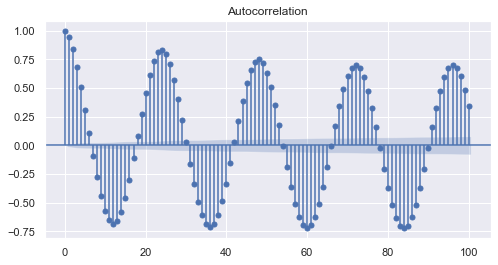

In [220]:
plot_acf(hourly_data_processed_P.vehicles_per_hour, lags=100)
plt.show()

The autocorrelation plot or correlogram summarizes the strength of the relationship from -1 to 1 between a value and a lag of k.  The 95% confidence interval is shown in the blue cone. The detrended data shows strong daily and weekly cyclicity. The high pearson coefficients indicate that past values are strongly correlated with future values.

Partial auto-correlation uses a similar approach to autocorrelation but calculates only the remaining correlation not explained by the previous lags. The 0 index value is the first row compared against itself which has an r2 of 1.  You can see that the previous two hours of data are predictive.

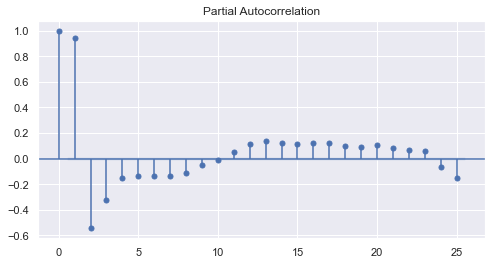

In [221]:
plot_pacf(hourly_data_processed_P.vehicles_per_hour, lags=25)
plt.show()

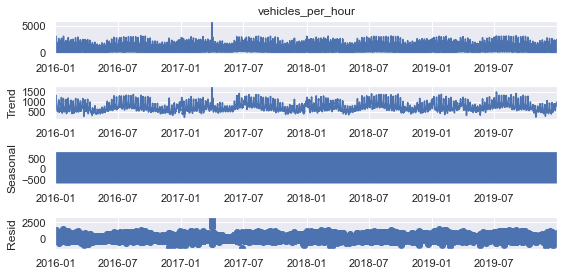

In [222]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(hourly_data_processed_P.vehicles_per_hour, model="additive")
decompose_data.plot()
plt.show()

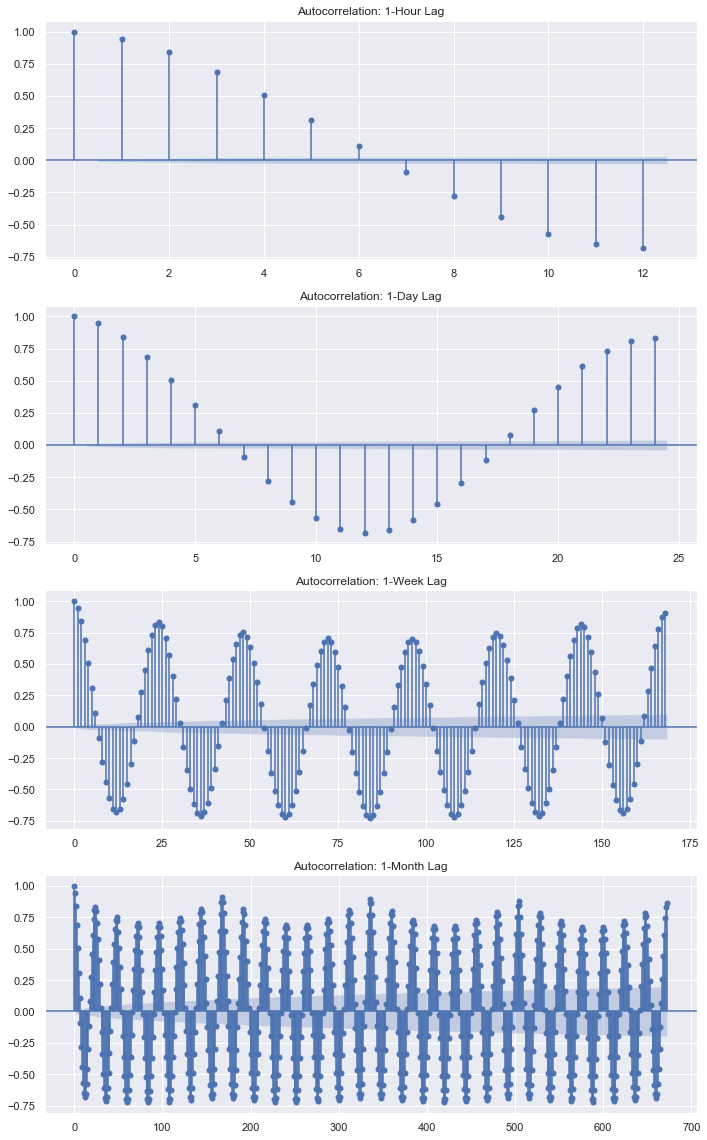

In [223]:
import statsmodels.tsa.api as smt

#create plots with different lag terms

def plot_multi_acf(data, lags, titles, ylim=None, partial=False):
    num_plots = len(lags)
    fig, ax = plt.subplots(len(lags), 1, figsize=(10, 4 * num_plots));
    if num_plots == 1:
        ax = [ax]
    acf_func = smt.graphics.plot_pacf if partial else smt.graphics.plot_acf
    for idx, (lag, title) in enumerate(zip(lags, titles)):
        fig = acf_func(data, lags=lag, ax=ax[idx], title=title);
        if ylim is not None:
            ax[idx].set_ylim(ylim);

    fig.tight_layout();

period_minutes = 60
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)
samples_per_month=int(4*samples_per_week)

lags = [12 * samples_per_hour, samples_per_day, samples_per_week, samples_per_month]
titles= ['Autocorrelation: 1-Hour Lag',
         'Autocorrelation: 1-Day Lag',
         'Autocorrelation: 1-Week Lag',
         'Autocorrelation: 1-Month Lag'
        ]

plot_multi_acf(hourly_data_processed_P.vehicles_per_hour, lags, titles)

# after https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/

## Model Assessment Tools

In [224]:
#Define function to plot residuals of a model and a density distribution

# Plot residual errors
def resid_plots(model_of_interest) :
    residuals = pd.DataFrame(model_of_interest.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

In [225]:
# Define function to create accuracy metrics
def forecast_accuracy(prediction, test):
    mape = np.mean(np.abs(prediction - test)/np.abs(test))  # MAPE
    me = np.mean(prediction - test)             # ME
    mae = np.mean(np.abs(prediction - test))    # MAE
    mpe = np.mean((prediction - test)/test)   # MPE
    rmse = np.mean((prediction - test)**2)**.5  # RMSE
    corr = np.corrcoef(prediction, test)[0,1]   # corr
    mins = np.amin(np.hstack([prediction[:,None], 
                              test[:,None]]), axis=1)
    maxs = np.amax(np.hstack([prediction[:,None], 
                              test[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  
            'corr':corr, 'minmax':minmax})

# modified from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### Arima

Arima data needs to be further processed. An ARIMA model can't use additional independent variables such as temperature or precipitation.
The Model 

### weekly Arima Model for testing

In [226]:
import pandas as pd

#resample data to weekly for direction "P" (primary/West)
weekly_data_arima_P = hourly_data_processed_P[['vehicles_per_hour']].resample('W').sum()
weekly_data_arima_P.rename(columns = {'vehicles_per_hour':'vehicles_per_week'}, inplace = True)


#partial weeks due to data pull skew low at the beginning and end of the data. 
#Exclude first and last row of data
weekly_data_arima_P = weekly_data_arima_P.iloc[1:-1 , :]

weekly_data_arima_P.head(3)

vehicles_per_week
count_datetime                   
2016-01-10               116501.0
2016-01-17               107741.0
2016-01-24               126101.0

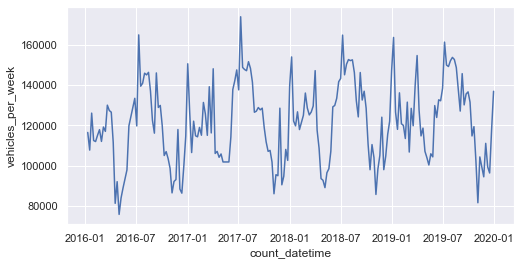

In [227]:
sns.lineplot(data=weekly_data_arima_P, x=weekly_data_arima_P.index, y="vehicles_per_week")
sns.set(rc = {'figure.figsize':(16,5)})

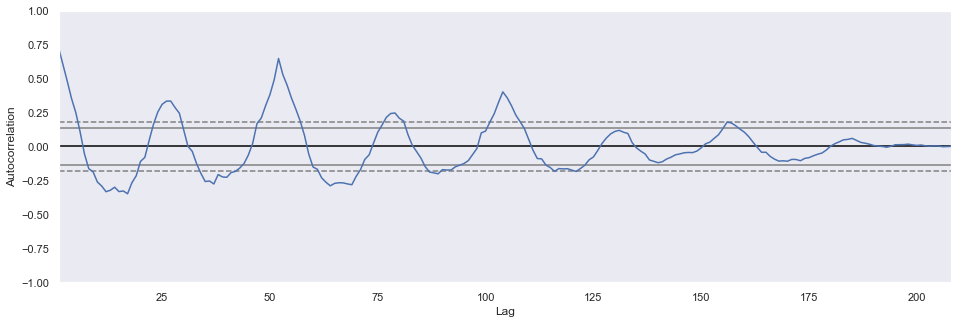

In [228]:
#Chack autocorrelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(weekly_data_arima_P['vehicles_per_week'])
plt.show()

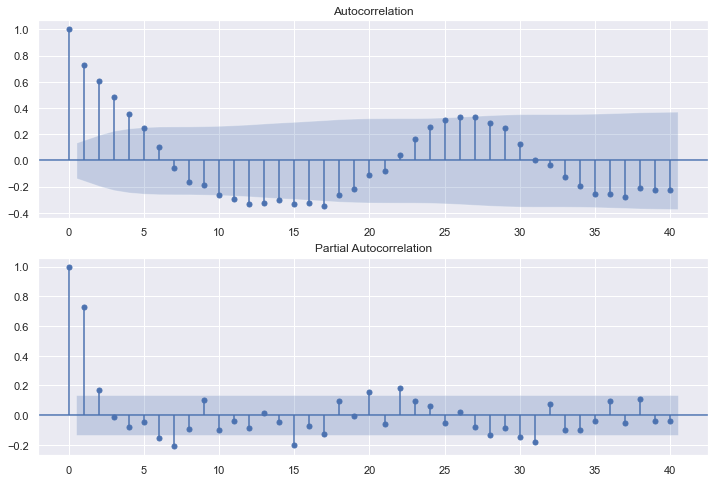

In [229]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weekly_data_arima_P['vehicles_per_week'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weekly_data_arima_P['vehicles_per_week'].dropna(),lags=40,ax=ax2)

In [230]:
# Again testing if data is stationary
stationary_test=adfuller(weekly_data_arima_P['vehicles_per_week'].dropna())
print('p-value: %f' % stationary_test[1])

#small p values, data are stationary (d=0)

p-value: 0.000001


In [231]:

from statsmodels.tsa.stattools import acf

#X = weekly_data_arima_P.values.astype('float64')
X=weekly_data_arima_P

## Create Training and Test
size = int(len(X) * .85)


train_weekly= X.vehicles_per_week[:size]
test_weekly = X.vehicles_per_week[size:len(X)]

#
#train_weekly = df.value[:85]
#test_weekly = df.value[85:]

In [232]:
#weekly_fit.forecast(size, alpha=0.05)

In [286]:
# For non-seasonal data
# Manual Arima Specification based off of the auto-correlation and partial auto-correlation plots
#p=3, d=0, q=4 

from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train_weekly,order=(2,0,2))
weekly_fit=model.fit()
weekly_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      vehicles_per_week   No. Observations:                  176
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1919.958
Date:                Tue, 14 Jun 2022   AIC                           3851.916
Time:                        20:31:27   BIC                           3870.939
Sample:                    01-10-2016   HQIC                          3859.631
                         - 05-19-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.206e+05   1629.049     74.005      0.000    1.17e+05    1.24e+05
ar.L1          1.8286      0.053     34.264      0.000       1.724       1.933
ar.L2         -0.8719      0.052    -16.673      0.000      -0.974      -0.769
ma.L1         -1.3073      0.088    -14.819      0.000      -1.480      -1.134
ma.L2          0.3656      0.096      3.814      0.000       0.178       0.554
sigma2      1.905e+08      0.030   6.31e+09      0.000     1.9e+08     1.9e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.46
Prob(Q):                              0.87   Prob(JB):                         0.11
Heteroskedasticity (H):               1.01   Skew:                             0.34
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.02e+25. Standard errors may be unstable.
"""

32
32


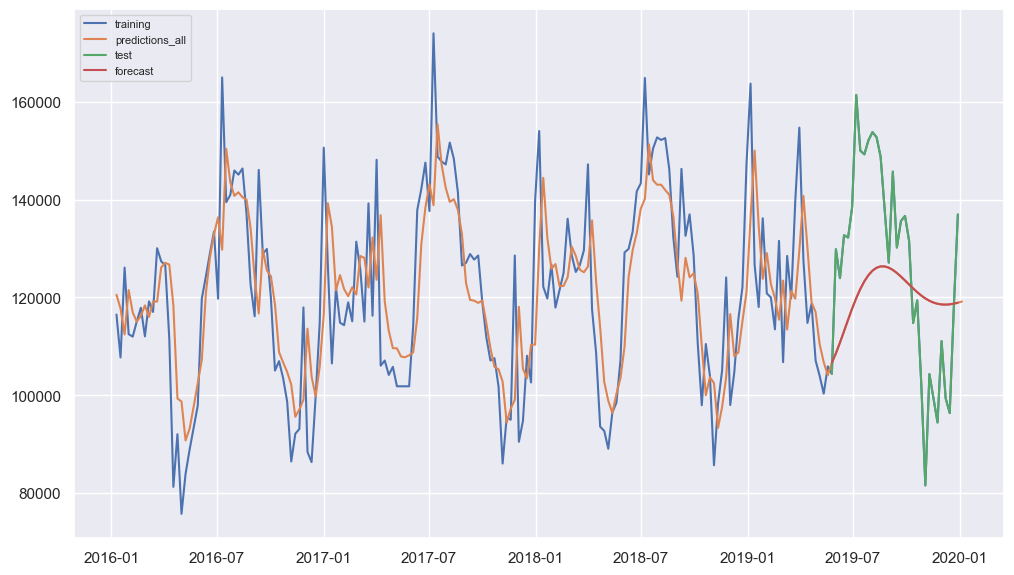

In [287]:

train_length=size
total_length=len(X)
forecast_length=total_length-train_length

print(len(test_weekly))
print(forecast_length)

#forecast out to compare with test data
fc=weekly_fit.forecast(forecast_length)


weekly_predict=pd.Series(weekly_fit.predict(start=0,end=total_length, data=X))
#weekly_predict

# Make as pandas series
fc_series = pd.Series(fc, index=test_weekly.index)
plt.figure(figsize=(12,7), dpi=100)
plt.plot(X, label='training')
plt.plot(weekly_predict, label='predictions_all')
plt.plot(test_weekly, label='test')
plt.plot(fc_series, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [274]:
# Check max index of training data
#df_1.sort_index(ascending=True)
#print(train_weekly.idxmax())
#train_weekly.head(15)
print(X.sort_index(ascending=False).head(10))
print(train_weekly.sort_index(ascending=False))


                vehicles_per_week
count_datetime                   
2019-12-29               136947.0
2019-12-22               117804.0
2019-12-15                96383.0
2019-12-08                99406.0
2019-12-01               111094.0
2019-11-24                94472.0
2019-11-17                99403.0
2019-11-10               104353.0
2019-11-03                81603.0
2019-10-27               102345.0
count_datetime
2019-05-19    105918.0
2019-05-12    100353.0
2019-05-05    103982.0
2019-04-28    107143.0
2019-04-21    118672.0
                ...   
2016-02-07    111992.0
2016-01-31    112497.0
2016-01-24    126101.0
2016-01-17    107741.0
2016-01-10    116501.0
Freq: -1W-SUN, Name: vehicles_per_week, Length: 176, dtype: float64


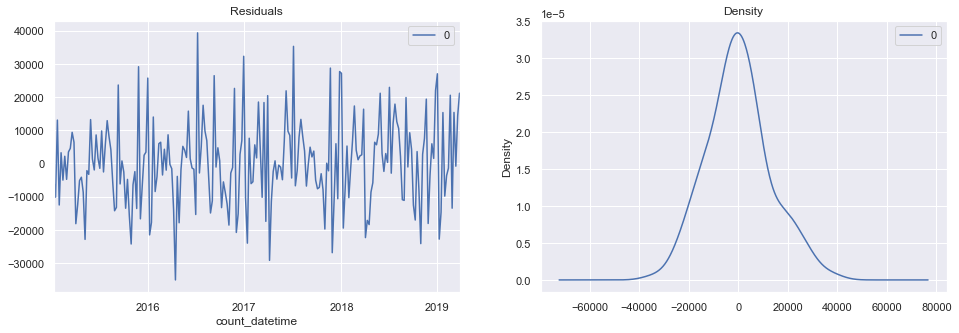

In [116]:
resid_plots(weekly_fit)

In [117]:
#forecast_accuracy(fc_series,test_weekly)

### Model Discussion
The Arima model with p,d,q set as 304 has a directionally correct prediction for the test data.  The model is underpredicting relative to actuals for Summer months and overpredicting the Fall months.
The data are stationay, but we may need to add seasonality to the trend.  We can do this with SARIMA.  First we will attempt an auto-Arima and see if we can improve the hyperparameters.

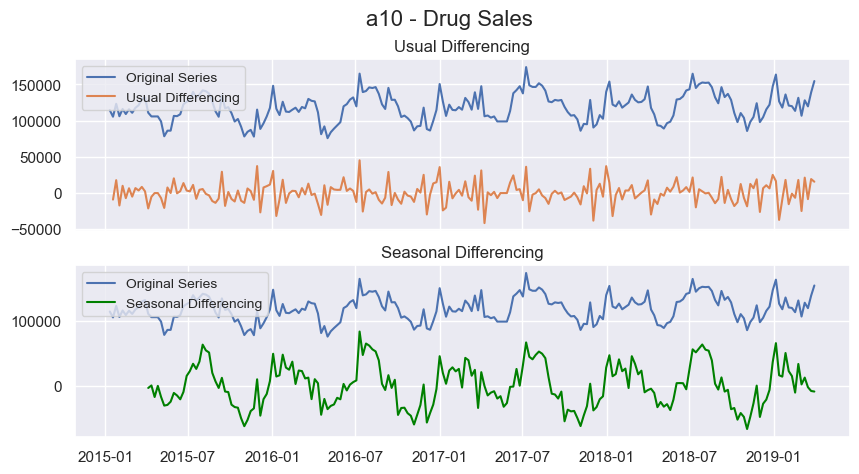

In [118]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(train_weekly[:], label='Original Series')
axes[0].plot(train_weekly[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal Differencing
axes[1].plot(train_weekly[:], label='Original Series')
axes[1].plot(train_weekly[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [290]:
#from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
auto_weekly_arima = pm.auto_arima(train_weekly, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_weekly_arima.summary())

C:\Users\ckitc\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3876.477, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4624.364, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4505.554, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3878.473, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3878.534, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4478.110, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3880.476, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3859.258, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3921.888, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3860.902, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3860.170, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3860.010, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3

208
32
32


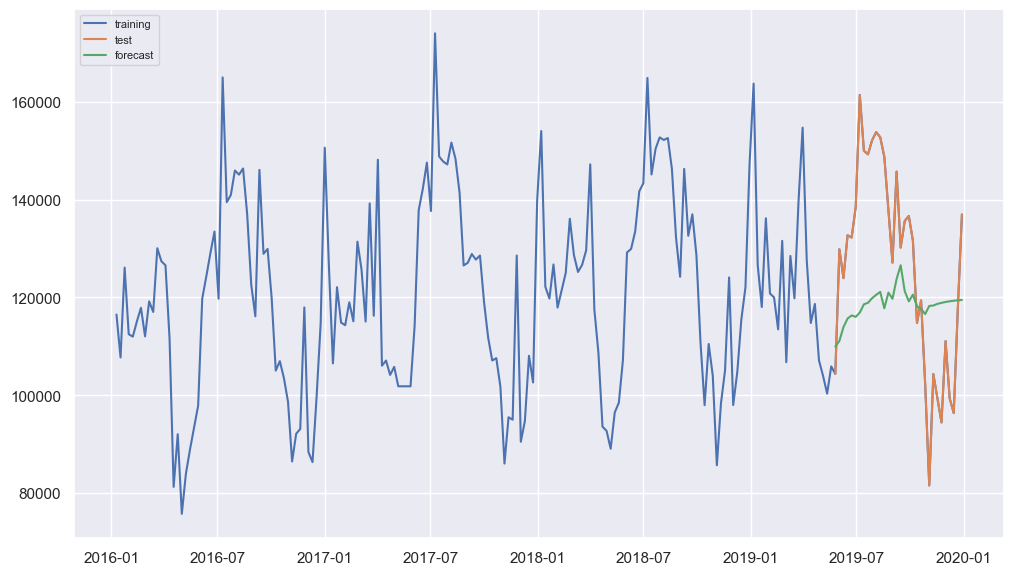

In [291]:
# Plot Auto  ARIMA
#auto_weekly_sarima
train_length=size
total_length=len(X)
forecast_length=total_length-train_length
fc=auto_weekly_sarima.predict(n_periods=forecast_length)

print(total_length)
print(len(test_weekly))
print(forecast_length)


weekly_predict=pd.Series(auto_weekly_arima.predict(start=0,end=total_length, data=X))
#weekly_predict

# Forecast
#fc = auto_weekly_sarima.forecast(80)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_weekly.index)
plt.figure(figsize=(12,7), dpi=100)
plt.plot(X, label='training')
#plt.plot(weekly_predict, label='predictions_all')
plt.plot(test_weekly, label='test')
plt.plot(fc_series, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [288]:
#Auto SARIMA
# Seasonal - fit stepwise auto-ARIMA
auto_weekly_sarima = pm.auto_arima(train_weekly, start_p=1, start_q=1,
                         test='adf',
                         max_p=20, max_q=20, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=False)

auto_weekly_sarima.summary()

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3980.349, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=3966.454, Time=0.04 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=3964.171, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=3981.817, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=3968.450, Time=0.22 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=3966.166, Time=0.58 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=3960.153, Time=0.13 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=3964.682, Time=0.86 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3921.888, Time=0.02 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3916.846, Time=0.06 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3915.786, Time=0.16 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3923.605, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3918.840, Time=0.22 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=3917.786, Time=0.68 sec


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  176
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood               -1921.829
Date:                                 Tue, 14 Jun 2022   AIC                           3855.657
Time:                                         20:35:38   BIC                           3874.680
Sample:                                              0   HQIC                          3863.373
                                                 - 176                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.94e+04   8550.478      3.438      0.001    1.26e+04    4.62e+04
ar.L1          0.5835      0.073      7.996      0.000       0.440       0.727
ar.L2          0.1710      0.071      2.397      0.017       0.031       0.311
ma.S.L12      -0.1331      0.073     -1.826      0.068      -0.276       0.010
ma.S.L24       0.1558      0.111      1.401      0.161      -0.062       0.374
sigma2      1.862e+08      0.389   4.79e+08      0.000    1.86e+08    1.86e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.84
Prob(Q):                              0.94   Prob(JB):                         0.09
Heteroskedasticity (H):               1.12   Skew:                             0.35
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.76e+24. Standard errors may be unstable.
"""

208
32
32


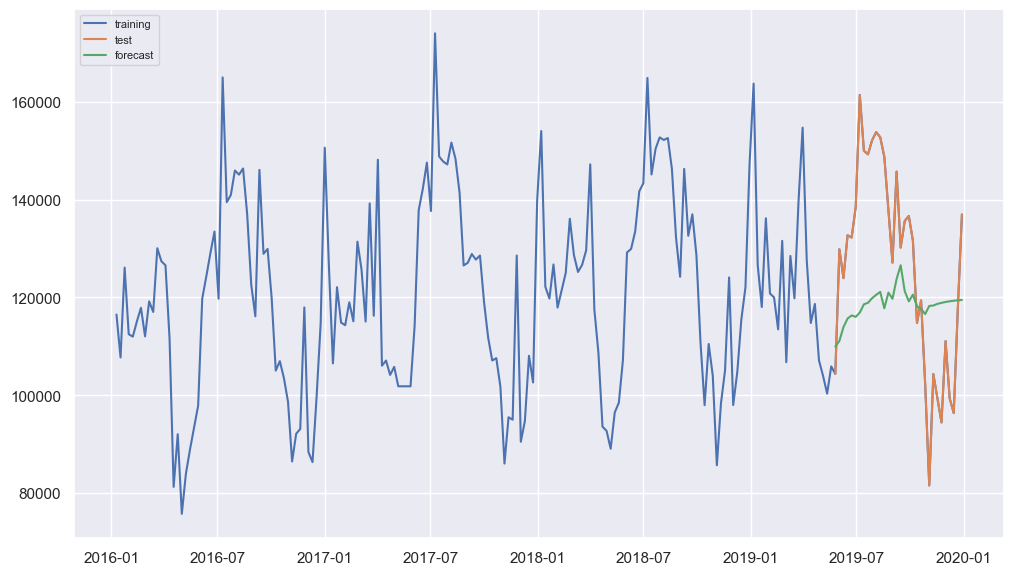

In [289]:
# Plot AutoSarima
#auto_weekly_sarima
train_length=size
total_length=len(X)
forecast_length=total_length-train_length
fc=auto_weekly_sarima.predict(n_periods=forecast_length)

print(total_length)
print(len(test_weekly))
print(forecast_length)


weekly_predict=pd.Series(auto_weekly_sarima.predict(start=0,end=total_length, data=X))
#weekly_predict

# Forecast
#fc = auto_weekly_sarima.forecast(80)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_weekly.index)
plt.figure(figsize=(12,7), dpi=100)
plt.plot(X, label='training')
#plt.plot(weekly_predict, label='predictions_all')
plt.plot(test_weekly, label='test')
plt.plot(fc_series, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [122]:
## Auto Arima
#train_index=train_weekly.set_index('count_datetime')
##Specify the value range for parameters
#weekly_fit_auto = pm.auto_arima(train_index['value'], 
#                          start_p=0, start_q=0,d=1, max_p=5, 
#                          max_q=5, start_P=0, D=None, start_Q=0, max_P=5, 
#                          max_D=5, max_Q=5,stepwise=True,seasonal=True)
#prediction=[]
##Recurrently predict following week and add the data into training model once we have predicted that week
#for i in test['value']:
#    predict=model.weekly_fit_auto(n_periods=1)[0]
#    prediction.append(predict)
#    weekly_fit_auto.update(i)
#from sklearn.metrics import mean_absolute_error
#print(mean_absolute_error(test['value'], prediction))
##8863.74

In [123]:
#weekly_data_arima_P['forecast']=model_fit.predict(dynamic=True)
#df[['Sales','forecast']].plot(figsize=(12,8))

In [124]:
# hourly arima model
hourly_data_arima_P = hourly_data_processed_P[['vehicles_per_hour']]
hourly_data_arima_P['vehicles_per_hour'] = pd.to_numeric(hourly_data_arima_P['vehicles_per_hour'])
hourly_data_arima_P.head(3)


C:\Users\ckitc\AppData\Local\Temp\ipykernel_24088\1929409918.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



vehicles_per_hour
count_datetime                        
2015-01-01 00:00:00               81.0
2015-01-01 01:00:00               70.0
2015-01-01 02:00:00               41.0

# To fit an ARIMA model we need to determine several hyperparamters.
We need to specify p,d, and q in that order as arguments for the model.
These parameters are derived for the autocorrelation and partial correlation plots.
To derive the order of differencing "d" we use the Augmented Dickey-Fuller to establish if the data are "stationary" or if they need additional differencing.  The test has a very low p-value indicating that the series is "stationary", the proposed value for d is "0"

Next we establish "p", the order for the autoregressive model (the "AR" in ARIMA).  On the partial-autocorrrelation plot we select the lag value with the largest correlation, 1.

Finally, we derive "q", the moving average, from the ACF plot.  We are looking to determine how many lag values are significant in predicting a value (10).  

Our proposed paramters for the ARIMA model are: p=1, d=0,q= 10.


In [125]:
#Evaluate an ARIMA model for Westbound Traffic (primary)

from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


X = hourly_data_arima_P.values.astype('float64')
size = int(len(X) * .8)
train, test = X[0:size], X[size:len(X)]

arima_model_p=ARIMA(train, order=(1,0,10))
arima_model_p=arima_model_p.fit()
print(arima_model_p.summary())
#code excerpt from 
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                35040
Model:                ARIMA(1, 0, 10)   Log Likelihood             -225672.993
Date:                Tue, 14 Jun 2022   AIC                         451371.985
Time:                        06:53:46   BIC                         451482.021
Sample:                             0   HQIC                        451407.033
                              - 35040                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        703.6062     15.500     45.393      0.000     673.226     733.986
ar.L1          0.6655      0.008     79.615      0.000       0.649       0.682
ma.L1          0.6123      0.008     75.808      0.0

In [126]:
#import statsmodels.api as sm
#import matplotlib.pyplot as plt
#
##hourly_data_arima_P['prediction']=arima_model_p.predict(dynamic=True)
#
#hourly_data_arima_P_out=hourly_data_arima_P
#hourly_data_arima_P_out.loc[:,'prediction'] = arima_model_p.predict(dynamic=True)
#hourly_data_arima_P_out[['vehicles_per_hour','prediction']].plot(figsize=(12,8))

In [127]:
print(hourly_data_arima_P.min())
print(hourly_data_arima_P.max())

vehicles_per_hour    0.0
dtype: float64
vehicles_per_hour    5625.0
dtype: float64


In [128]:
#hourly_data_arima_P.dtypes

In [129]:
#hourly_data_arima_P.dtypes

In [130]:
#tidbits
#from statsmodels.graphics.tsaplots import plot_predict
#
#plot_predict(weekly_fit, dynamic=False)
#weekly_data_arima_P.plot()
##weekly_fit.plot_predict(dynamic=False)
#plt.show()

